# San Diego Police Department Stops per Race

In [119]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### Introduction

With the death of George Floyd in police custody at the end of May 2020, the national conversation in the United States has once again shifted to the debate on police bias and systemic racism. As well as nearly every other major city, the city of San Diego has seen protests against its current police department, on the argument of unfair, racially biased police activity.  

Using data related to the demographics of San Diego's population and the stops made by the San Diego Police Department, this report will analyze data in an attempt to identify what, if any, biases may exist. This report is meant to determine what groups, if any, are disproportionately under or over represented in police stops of persons.

This report is independent and unfunded, without any affiliation to any groups or entities. This report is not intended to draw conclusions on why a group may or may not be over or under represented; the intention is to identify if any biases seem to exist from the available data. Any conclusions or observations not explicitly listed in this report are drawn at the discretion of the reader.

### Data

#### Data Sources

The data used for this report consists of San Diego Police Department (herein SDPD) data and US Census data. 

The SDPD data "is collected according to requirements set forth in Government Code section 12525.5 that was enacted as a result of the Racial and Identity Profiling Act of 2015 (AB 953), also known as RIPA." All of the data used is public and available at https://data.sandiego.gov/datasets/. 

Specifically, this report will use "Race of Persons Stopped" in order to establish the demographics of police stops (https://data.sandiego.gov/datasets/police-ripa-race/), and "Reason for Stop" to establish the reason for stopping a person (https://data.sandiego.gov/datasets/police-ripa-stop-reason/). 

US Census data will be used to define the racial demographic percentages of the city of San Diego, based on the 2010 US Census, as the 2020 Census is currently taking place. (https://web.archive.org/web/20120802190059/http://quickfacts.census.gov/qfd/states/06/0666000.html).

#### Data Limitations

The SDPD data on race is based on the stopping officer's perception of the stopped person's race, which may or may not be an accurate reflection with the race the stopped person identifies as / with. 

Both the data of SDPD and the Census do not have the same defined racial values, requiring certain values to be merged or omitted. Due to omission, only 97.6% of the Census data may be accurately used.

#### Data Sorting and Cleaning

##### Census Data

From the Census data, only the information relevant to the demographic makeup of San Diego will be used.

In order to have the same racial groups present in both Census and SDPD data, the Census values of "White" and "Multiracial" will be dropped, where "White / Non-Latino" will be renamed as "White". "Asian" and "Hawaiian / other Pacific Islander" will be merged into the group "Asian". The values for "Black / African American" will be renamed "Black", and the values for "Hispanic / Latino/a" will be renamed "Latinx", in respect to currently common self identification trends. "Native American" will remain unchanged.

In [50]:
# Demographics DF = df_dem
df_sdc = pd.read_excel('data/2010SDcensus.xls')
df_sdc = df_sdc[['People QuickFacts', 'San Diego']]
df_sdc = df_sdc.rename(columns = { 'People QuickFacts' : 'Race', 'San Diego' : 'Percent'})
df_dem = df_sdc.iloc[9:17]
df_dem['Percent'] = df_dem['Percent'].str.rstrip('%').astype('float')
df_dem = df_dem.reset_index(drop = True)
df_dem = df_dem.rename({0: 'White', 1: 'Black', 2: 'Native American', 3: 'Asian', 4: 'Hawaiian / other PI', 5: 'Multiracial', 6 : 'Latinx', 7 : 'White / non-Latinx'}, axis='index')
df_dem = df_dem.sort_values(by = 'Percent', ascending = False)
df_dem = df_dem.drop(['White', 'Multiracial', 'Asian', 'Hawaiian / other PI'])
new_row = {'Race': 'Asian, Native Hawaiian and Other Pacific Islander, percent, 2010(a)', 'Percent': 16.4}
df_dem = df_dem.append(new_row, ignore_index = True)
df_dem = df_dem.rename({2: 'Black',
                          3: 'Native American',
                          1: 'Latinx',
                          0: 'White',
                          4: 'Asian'},
                          axis='index')                    
df_dem = df_dem.sort_values(by = 'Percent', ascending = False)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### SDPD Data

From the SDPD data, both data sets will be merged on their Stop ID, and any duplicates or values which are missing crucial information are dropped. The data set is made up of the shared "Stop ID", the "Race" of each person stopped from the "Race of Persons Stopped" data and the "Reason" of each stop from the "Reason for Stop" data.  

In order to match Census racial values, "Asian", "Middle Eastern or South Asian", and "Pacific Islander" will be merged into the group "Asian". Similarly, "Black" will be used for "Black/African American" and "Latinx" will be used for "Hispanic/Latino/a", for the same reasons mentioned with the Census Data. "White" and "Native American" will remain unchanged. The number of stops per race will be divided by the total number of stops, in order to establish a percent of stops that can be compared to the Census data.

The data values for "Reason for Stop" will be turned into percents, by racial makeup, of the total number of stops for a given reason. The two reasons that will be focused on are "Traffic Violation" and "Reasonable Suspicion", which together account for over 93% of all stops.

In [27]:
# Stop ID DF = df_sr
df_stop_reason = pd.read_csv('http://seshat.datasd.org/pd/ripa_stop_reason_datasd.csv')
df_race = pd.read_csv('http://seshat.datasd.org/pd/ripa_race_datasd.csv')
df_stop_reason = df_stop_reason[['stop_id','reason_for_stop']]
df_race = df_race[['stop_id','race']]
df_sr = pd.merge(df_race, df_stop_reason, on='stop_id')
df_sr.drop_duplicates(subset = 'stop_id', 
                     keep = False, inplace = True) 
df_sr = df_sr.reset_index(drop = True)
df_sr = df_sr.rename(columns = { 'stop_id' : 'Stop ID', 'race' : 'Race', 'reason_for_stop' : 'Reason'})
df_sr = df_sr.replace(['Asian', 'Middle Eastern or South Asian', 'Pacific Islander'], 'Asian')

In [4]:
# Percentage of stops per race = df_rc
per = df_sr['Race'].value_counts() / 253513 * 100
df_rc = pd.DataFrame(data=per)
df_rc = df_rc.reset_index(drop=False)
df_rc = df_rc.rename(columns = { 'index' : 'Race', 'Race' : 'Percent'})
df_rc['Percent'] = df_rc['Percent'].round(decimals=1)
df_rc = df_rc.rename({2: 'Black',
                          4: 'Native American',
                          1: 'Latinx',
                          0: 'White',
                          3: 'Asian'},
                          axis='index')  
df_rc = df_rc.sort_values(by = 'Percent', ascending = False)

In [5]:
# DF for black race values = df_black
df_black = df_sr[df_sr['Race'] == 'Black/African American']
df_black = df_black.reset_index(drop = True)
df_black = df_black['Reason'].value_counts()

In [6]:
# DF for white race values = df_white
df_white = df_sr[df_sr['Race'] == 'White']
df_white = df_white.reset_index(drop = True)
df_white = df_white['Reason'].value_counts()

In [7]:
# DF for latinx race values = df_latinx
df_latinx = df_sr[df_sr['Race'] == 'Hispanic/Latino/a']
df_latinx = df_latinx.reset_index(drop = True)
df_latinx = df_latinx['Reason'].value_counts()

In [8]:
# DF for native american race values = df_na
df_na = df_sr[df_sr['Race'] == 'Native American']
df_na = df_na.reset_index(drop = True)
df_na = df_na['Reason'].value_counts()

In [10]:
# DF for asian race values = df_asian
df_asian = df_sr[df_sr['Race'] == 'Asian']
df_asian = df_asian.reset_index(drop = True)
df_asian = df_asian['Reason'].value_counts()

In [60]:
# df for reason of stop by race = df_reason
df_reason = pd.DataFrame(data = {'White' : df_white,
                     'Latinx' : df_latinx,
                     'Black' : df_black,
                     'Asian' : df_asian,
                     'Native American' : df_na})
df_reason = df_reason.reset_index(drop=False)
df_reason = df_reason.rename({0: 'Consented Search',
                          1: 'Violation of School Policy',
                          2: 'Truancy',
                          3: 'Warrant or Wanted Person',
                          4: 'Parole or Probation Related',
                          5: 'Education Code Discipline',
                          6: 'Reasonable Suspicion',
                          7: 'Traffic Violation'},
                          axis='index') 
df_reason = df_reason.rename(columns={'index' : 'Reason for Stop'})
df_reason['Total'] = df_reason.sum(axis=1)

In [61]:
# df for percent of reason stopped by race = df_rper
df_rper = df_reason
cols = ['White', 'Latinx', 'Black', 'Asian', 'Native American', 'Total']
df_rper[cols] = df_rper[cols].div(df_rper[cols].sum(axis=0), axis=1).multiply(100).round(decimals=1)

### Methodology

#### Data Analysis

All present demographic data will be presented as percentages of a population, in order to easily compare values from various data sets. This report is intended for a general audience and will not go into great depth in terms of modeling and testing.

A ratio between data sets will be established in order to define the likelihood of a person being stopped based on their race, where the value of 1 is default / proportional, a value of less than one being disproportionately less likely to be stopped, and a value greater than 1 being disproportionately more likely to be stopped. The standard deviation will be mentioned if any group of persons, or "Race", falls outside of it.

In [29]:
# Demographics of stops and population DF = df_merged
# Used to compare both data frames
df_merged = df_rc.merge(df_dem, how='outer', left_index=True, right_index=True)
df_merged = df_merged.drop(columns=['Race_x'])
df_merged = df_merged.rename(columns = { 'Percent_x' : 'Stop Percent', 'Race_y' : 'Race', 'Percent_y' : 'Population Percent'})
col = ['Race', 'Population Percent', 'Stop Percent']
df_merged = df_merged.reindex(columns=col)
df_merged = df_merged.sort_values(by = 'Stop Percent', ascending = False)

In [31]:
# Ratio of population to stop percent = df_ratio

pratio = df_merged.groupby('Race')['Population Percent'].mean()
sratio = df_merged.groupby('Race')['Stop Percent'].mean()
psratio = sratio / pratio

df_ratio = pd.DataFrame(data = psratio)

df_ratio = df_ratio.reset_index(drop=False)
df_ratio = df_ratio.rename(columns = { 0 : 'Stops per Population'})
df_ratio = df_ratio.drop(columns=['Race'])
df_ratio['Stops per Population'] = df_ratio['Stops per Population'].round(decimals=1)
df_ratio = df_ratio.rename({2: 'Black',
                          0: 'Native American',
                          3: 'Latinx',
                          4: 'White',
                          1: 'Asian'},
                          axis='index')  
df_ratio = df_ratio.sort_values(by = 'Stops per Population', ascending = False)
#df_ratio.std() <--- Stops per Population    0.978264

### Results

#### Demographics of San Diego

The demographics of San Diego, based on the Census data with the modifications mentioned in the Data section, are:

In [109]:
df_dem

,Race,Percent
White,"White persons not Hispanic, percent, 2010",45.1
Latinx,"Persons of Hispanic or Latino origin, percent,...",28.8
Asian,"Asian, Native Hawaiian and Other Pacific Islan...",16.4
Black,"Black persons, percent, 2010 (a)",6.7
Native American,"American Indian and Alaska Native persons, per...",0.6


Graphically, the population percentages are show below.

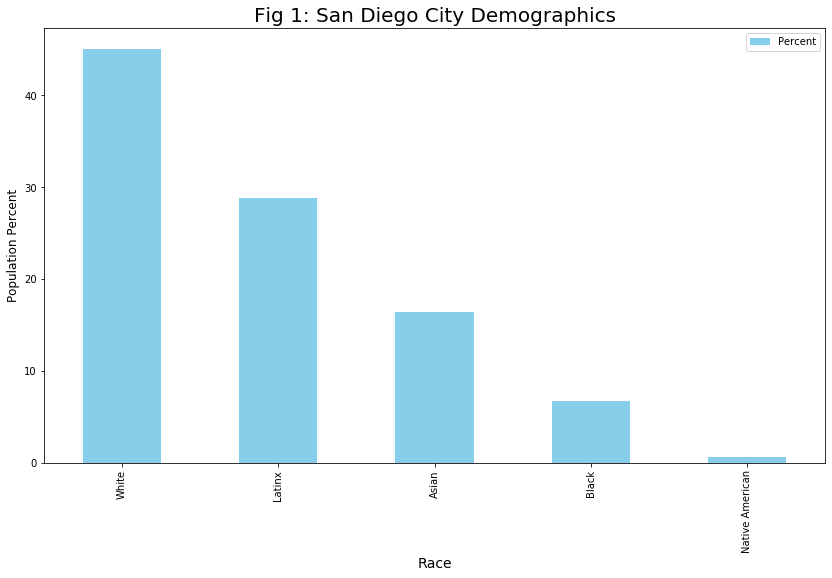

In [113]:
df_dem.plot(kind='bar', figsize=(14, 8), color='skyblue')

plt.xlabel('Race', fontsize = 14) 
plt.ylabel('Population Percent', fontsize = 12) 
plt.title('Fig 1: San Diego City Demographics', fontsize = 20) 

plt.show()

#### Police Stops in San Diego

The demographics of police stops in San Diego, based on SDPD data with the modifications mentioned in the Data section, are:

In [112]:
df_rc

,Race,Percent
White,White,42.7
Latinx,Hispanic/Latino/a,29.1
Black,Black/African American,18.7
Asian,Asian,9.2
Native American,Native American,0.2


Graphically, the stop percentages, by race, are shown below.

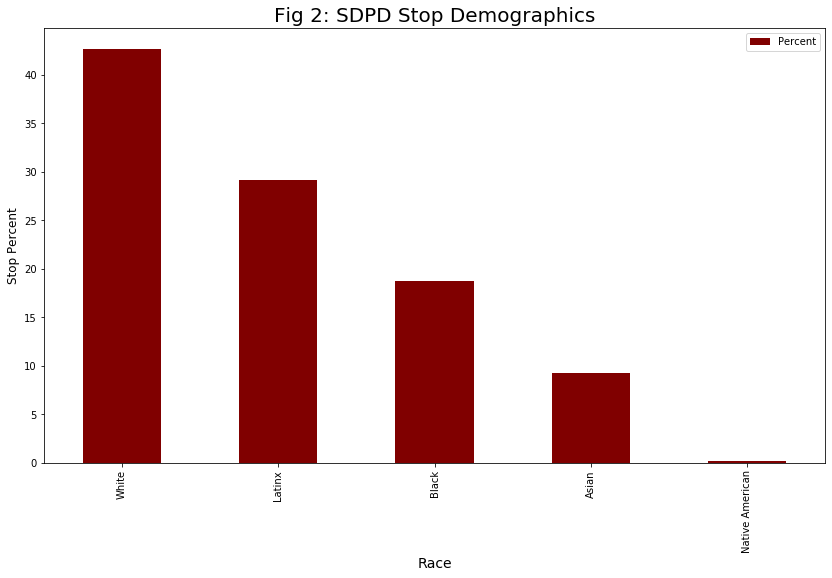

In [114]:
df_rc.plot(kind='bar', figsize=(14, 8), color='maroon')

plt.xlabel('Race', fontsize = 14) 
plt.ylabel('Stop Percent', fontsize = 12) 
plt.title('Fig 2: SDPD Stop Demographics', fontsize = 20) 

plt.show()

#### Populations Percent versus Stop Percent

Using the data from both the census and stop data, the demographics of the population versus persons stopped can be plotted next to one another to be compared visually, as shown in the table below.

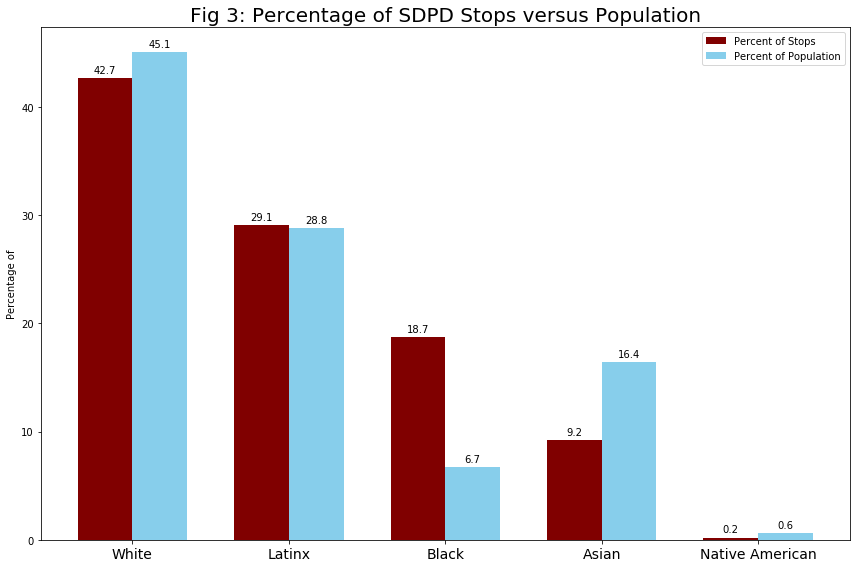

In [115]:
labels = ['White', 'Latinx', 'Black', 'Asian', 'Native American']
x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, df_merged['Stop Percent'], width, label='Percent of Stops', color='maroon')
rects2 = ax.bar(x + width/2, df_merged['Population Percent'], width, label='Percent of Population', color='skyblue')


ax.set_ylabel('Percentage of')
ax.set_title('Fig 3: Percentage of SDPD Stops versus Population', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(df_merged.index, fontsize=14)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

By dividing the stop per group percentage by the population percentage, a ratio of stop per population is established based on the data. A ratio of "1" implies an equal proportion of stops to population. The ratio is shown in the table below.

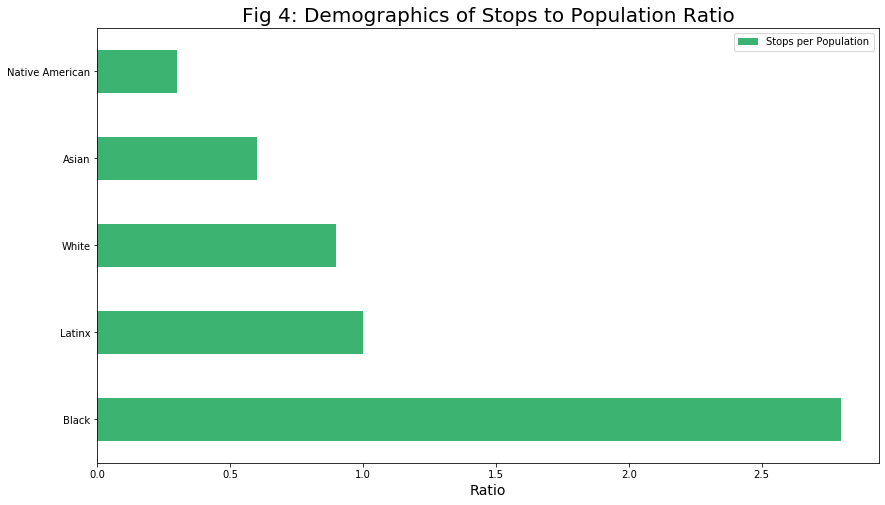

In [116]:
df_ratio.plot(kind='barh', figsize=(14,8), color='mediumseagreen')

plt.title('Fig 4: Demographics of Stops to Population Ratio', fontsize = 20)
plt.xlabel('Ratio', fontsize = 14)
                 
plt.show()

#### Reasons for Stops

Over 93% of police stops are listed as "Traffic Violation" or "Reasonable Suspicion", with "Traffic Violation" being slightly more common. Due to this, the data percentages are more solid and less influenced by outliers and "random events." Below, these values are compared.

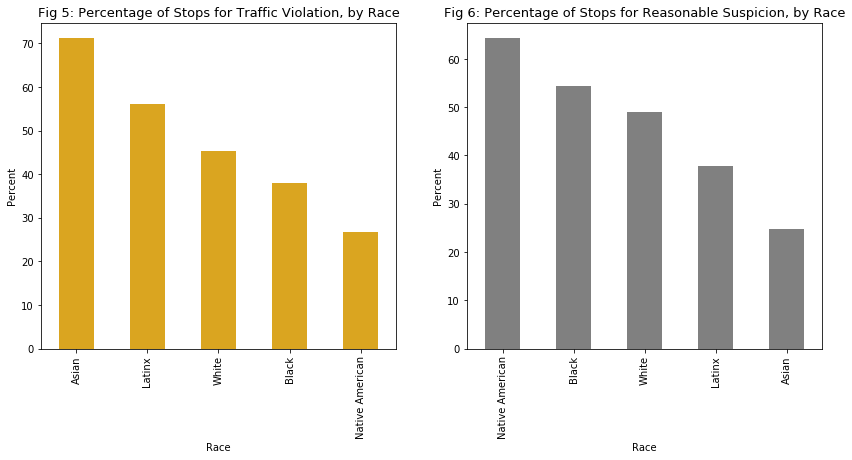

In [117]:
df_rstv = df_rper.iloc[6 : 8]
df_rstv = df_rstv.drop(columns={'Reason for Stop', 'Total'})
df_rstv = df_rstv.transpose()
df_rs = df_rstv['Reasonable Suspicion'].sort_values(ascending = False)
df_tv = df_rstv['Traffic Violation'].sort_values(ascending = False)

fig = plt.figure() 

ax0 = fig.add_subplot(1, 2, 1) 
ax1 = fig.add_subplot(1, 2, 2) 

# Subplot 1: Box plot
df_tv.plot(kind='bar', figsize=(14, 6), color='goldenrod', ax=ax0) 
ax0.set_title('Fig 5: Percentage of Stops for Traffic Violation, by Race', fontsize=13)
ax0.set_xlabel('Race')
ax0.set_ylabel('Percent')

# Subplot 2: Line plot
df_rs.plot(kind='bar', figsize=(14, 6), color= 'gray', ax=ax1) 
ax1.set_title ('Fig 6: Percentage of Stops for Reasonable Suspicion, by Race', fontsize=13)
ax1.set_ylabel('Percent')
ax1.set_xlabel('Race')

plt.show()

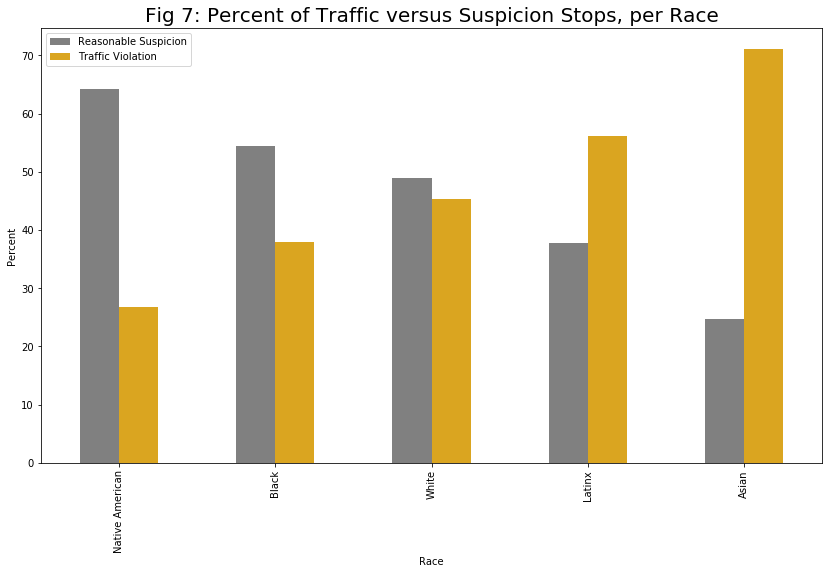

In [118]:
df_rstv2 = df_rstv.sort_values(by = 'Traffic Violation', ascending = True)
df_rstv2.plot(kind='bar', figsize = (14, 8), color=['gray', 'goldenrod'])
plt.title('Fig 7: Percent of Traffic versus Suspicion Stops, per Race', fontsize=20)
plt.xlabel('Race')
plt.ylabel('Percent')
plt.show()

### Suggestions

#### Observations

##### Population versus Stops

The data shows a disproportional relationship between race and likelihood of being stopped by the police. The ratio between the demographic percentages of stops and population are negligible for the "Latinx" persons, with the proportion of stops and population being nearly equal. "White" and "Asian" persons are somewhat less likely to be stopped by the police, and "Native American" persons is significantly less likely to be stopped by the police, though all three fall within a standard deviation of the ratio data. "Black" persons, however, is very significantly more like to be stopped by the police, falling nearly two standard deviations away from the 1:1 ratio.

Therefore, the data implies a bias in the likelihood that a person will be stopped based on their race. If a person is "Black", they are well over two and a half times (more than 250%) likelier to be stopped than what would be considered average.

##### Reasons for Stops

The data shows that "Native American" and "Black" persons are more likely to be stopped for "Reasonable Suspicion", whereas "Latinx" and "Asian" persons are more likely to be stopped for "Traffic Violations". "White" persons are more likely to be stopped for "Reasonable Suspicion", but only slightly.

Due to this, the data implies that "Native American" and "Black" persons are more likely to be perceived as engaging in suspicious or illegal activity, whereas "Latinx" and "Asian" persons are less likely to be perceived as engaging in similar activities.

#### Recommendations

Overall, the data implies that a negative bias does exist against "Black" persons, which increases the likelihood of being stopped in San Diego for "Reasonable Suspicion." Further, the data also implies a positive bias against "Asian" persons, which decreases the chances of being stopped in San Diego, particularly for "Reasonable Suspicion."

#### Data Improvements

Following the completion of the 2020 Census, it would be ideal to re-evaluate this report with updated information, due to the constant shifting of demographics and populations. Further, if data were available by zip code or another geographic value, the data could be sorted based regions and sorted to analyze the demographic breakdowns of each region, rather than the city as a whole.

Additional analysis performed on the results of each stop, rather than solely the reason, has the possibility to determine if there exists any justification behind the disproportionate number of stops.

### Conclusion

The data clearly shows certain demographics are stopped more or less often than others, by comparing the percentages of San Diego's population to the percentage of stops by the San Diego Police Department. Particularly, "Black" persons are significantly more likely, well over two and one half times, to be stopped than the next most stopped race. Further, the data shows that "Black" persons are more likely than average to be stopped under "Reasonable Suspicion," whereas "Asian" persons are significantly less likely to be stopped for "Reasonable Suspicion." 

The data processed and analyzed in this report implies that, when comparing the demographics of stops with the population of San Diego, baises do exist, as shown by the disproportion of the stop rate of each race. 